# Generate the Fit Configuration

This block generates the config file for the statistical fit.  Note that this block contains everything that we are allowed to modify in order to change the results of the fit!

In [1]:
%config InteractiveShell.ast_node_interactivity="last_expr_or_assign"
import json
import pathlib
import copy


def generateConfig(isDiscovery=False, separatebackgrounds=True):
    # Define Samples
    basepath="/data/users/mhance/tthh/"
    sig_paths=[basepath+"augmented_TTHH.root"]
    signal_name="tthh"
    
    bkg_paths=[basepath+"augmented_TTBB.root",
               basepath+"augmented_TTH.root",
               basepath+"augmented_TTZ.root"]

    
    # ===============================================================================================================
    # Define NN score bins.
    # To-do's:
    # -- Find optimal binning.
    # using "1-NNscore" will allow us to make a plot in log-x someday...  shouldn't change anything.
    variable = "1-NNscore"
    binning=[0, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
    #variable="NNscore"
    #binning = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.998, 0.999, 0.9995, 1]
    # ===============================================================================================================



    # ===============================================================================================================
    # 
    # Most things below here won't need to change, at least for VBFSUSY setups.
    #
    config = {
        "General": {
            "Measurement": "main",
            "POI": "mu",
            "HistogramFolder": "histograms/",
            "InputPath": "{SamplePaths}",
        },
        "Regions": [],
        "Samples": [],
        "Systematics": [],
        "NormFactors": [],
    }

    config["Regions"].append(
        {
            "Name": f"SR",
            "Filter": "NNscore>0",
            "Variable": variable,
            "Binning": binning,
        }
    )

    config["Samples"].append(
        {
            "Name": signal_name,
            "Tree": "t",
            "SamplePaths": sig_paths,
            "Weight": "weights",
            "Data": False,
        }
    )

    if separatebackgrounds:
        for bkg_path in bkg_paths:
            config["Samples"].append(
                    {
                        "Name": bkg_path.replace(".root", "").split("/")[-1].replace("augmented_","").lower(),
                        "Tree": "t",
                        "SamplePaths": bkg_path,
                        "Weight": "weights",
                        "Data": False,
                    }
            )
    else:
        config["Samples"].append(
                {
                    "Name": "background",
                    "Tree": "t",
                    "SamplePaths": bkg_paths,
                    "Weight": "weights",
                    "Data": False,
                }
        )

    asimovSamplePaths=bkg_paths
    if isDiscovery:
        asimovSamplePaths=sig_paths+bkg_paths
    config["Samples"].append(
        {
            "Name": "data",
            "Tree": "t",
            "SamplePaths": asimovSamplePaths,
            "Weight": "weights",
            "Data": True,
        }
    )
    
    # Define Systematics.  For now these are just flat systematics.
    # Should eventually define a shape systematic too.
    config["Systematics"].append(
        {
            "Name": "flat_uncertainty",
            "Up": {"Normalization": 0.00},
            "Down": {"Normalization": -0.00},
            "Samples": [sample["Name"] for sample in config["Samples"]],
            "Type": "Normalization",
        },
    )

    config["NormFactors"].append(
        {
            "Name": "mu",
            "Samples": signal_name,
            "Nominal": 1,
            "Bounds": [0, 5],
        }
    )

    # write out the config JSON file.
    cabinetry_config_yaml=signal_name+".yml"
    pathlib.Path(cabinetry_config_yaml).write_text(
        json.dumps(config, indent=4, sort_keys=True)
    )
    return cabinetry_config_yaml
    # ===============================================================================================================

In [2]:
# True makes discovery config, False makes limit config
cabinetry_config_yaml = generateConfig(True);

# Run the Fit 

Now run the fit.  Remove the ";" at the end of lines to see the output.

In [3]:
import cabinetry
cabinetry_config = cabinetry.configuration.load(cabinetry_config_yaml);

In [4]:
# create template histograms
cabinetry.template_builder.create_histograms(cabinetry_config);

SR_tth_Nominal has empty bins: [0 1 2]
SR_ttz_Nominal has empty bins: [0 1 2 3 4]


In [5]:
# perform histogram post-processing
cabinetry.template_postprocessor.run(cabinetry_config);

SR_tth_Nominal has empty bins: [0 1 2]
SR_ttz_Nominal has empty bins: [0 1 2 3 4]


/home/jupyter-mhance/.conda/envs/fitting_20210217/lib/python3.9/site-packages/cabinetry/contrib/matplotlib_visualize.py:75: RuntimeWarning: divide by zero encountered in log10
  np.power(10, 0.5 * (np.log10(bin_left_edges * bin_right_edges)))
/home/jupyter-mhance/.conda/envs/fitting_20210217/lib/python3.9/site-packages/cabinetry/contrib/matplotlib_visualize.py:180: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(bin_left_edges[0], bin_right_edges[-1])
/home/jupyter-mhance/.conda/envs/fitting_20210217/lib/python3.9/site-packages/cabinetry/contrib/matplotlib_visualize.py:187: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(bin_left_edges[0], bin_right_edges[-1])


figures/SR_prefit_log.pdf


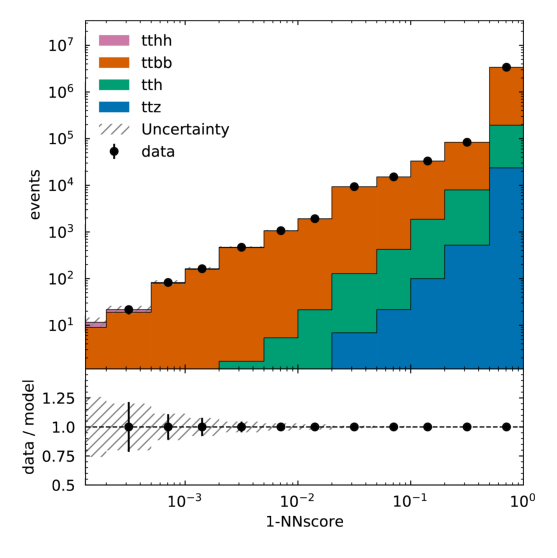

In [6]:
# visualize templates and data
import os
import shutil
shutil.rmtree("figures")
os.mkdir("figures")
cabinetry.visualize.data_MC_from_histograms(cabinetry_config, "figures/",log_scale_x=True)
import glob
import matplotlib.pyplot as plt
import wand
from wand.image import Image as WImage
from IPython.display import Image,IFrame

def showImageFromFile(filepath,resolution=200):
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(WImage(filename=filepath,resolution=resolution))

for fig_path in glob.glob("figures/*prefit_log.pdf"):
    print(fig_path)
    showImageFromFile(fig_path,1000)

In [7]:
# build a workspace
ws = cabinetry.workspace.build(cabinetry_config)
# save it for later
cabinetry.workspace.save(ws, cabinetry_config_yaml.replace(".yml", ".json"))

In [22]:
# run a fit
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data); # remove semicolon to see more output

W VariableMetricBuilder No improvement in line search


visualize pulls

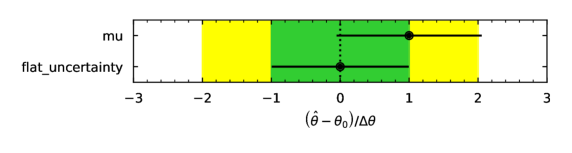

In [19]:
cabinetry.visualize.pulls(fit_results,"figures/")
showImageFromFile("figures/pulls.pdf")

 ... and correlation matrix

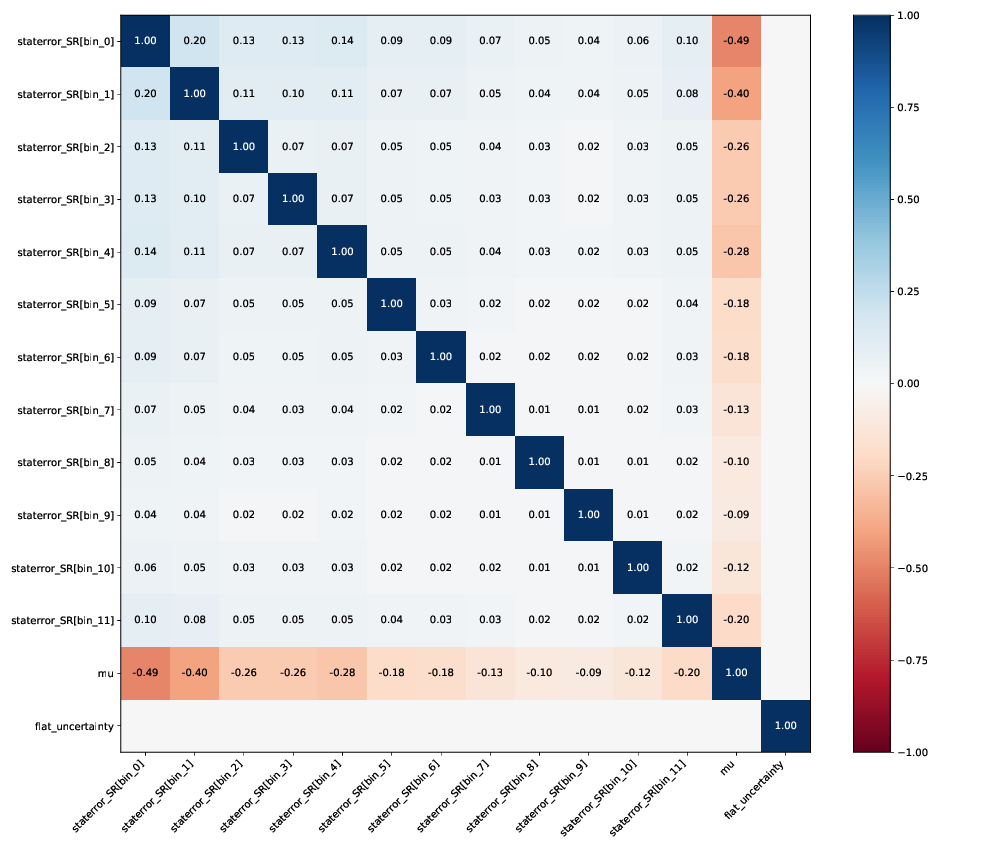

In [10]:
cabinetry.visualize.correlation_matrix(fit_results,"figures/")
correlation_matrix=WImage(filename="figures/correlation_matrix.pdf")
correlation_matrix

visualize post-fit distributions

/home/jupyter-mhance/.conda/envs/fitting_20210217/lib/python3.9/site-packages/cabinetry/contrib/matplotlib_visualize.py:75: RuntimeWarning: divide by zero encountered in log10
  np.power(10, 0.5 * (np.log10(bin_left_edges * bin_right_edges)))
/home/jupyter-mhance/.conda/envs/fitting_20210217/lib/python3.9/site-packages/cabinetry/contrib/matplotlib_visualize.py:180: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(bin_left_edges[0], bin_right_edges[-1])
/home/jupyter-mhance/.conda/envs/fitting_20210217/lib/python3.9/site-packages/cabinetry/contrib/matplotlib_visualize.py:187: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(bin_left_edges[0], bin_right_edges[-1])


figures/SR_postfit_log.pdf


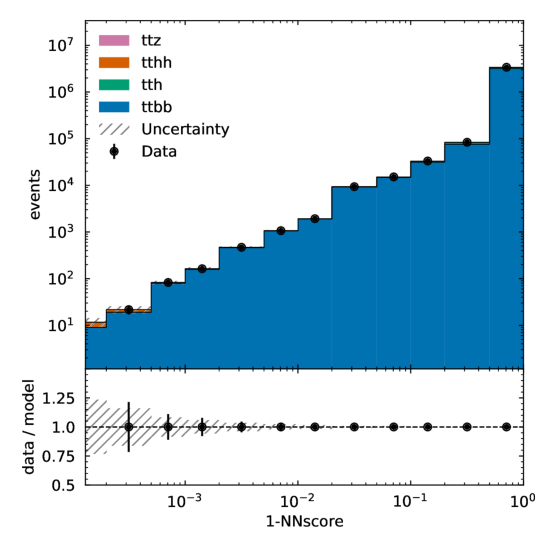

In [11]:
cabinetry.visualize.data_MC(model, data, config=cabinetry_config, fit_results=fit_results,log_scale_x=True)
for fig_path in glob.glob("figures/*postfit_log.pdf"):
    print(fig_path)
    showImageFromFile(fig_path)

# Run the limits

Now actually compute the upper limit.  This may take a while.  In the output figure, the place where the CL_S line crosses the black solid line corresponds to the signal strength that we can constrain with this fit.  If the signal strength is less than 1, then it means we can exclude the model at 95% confidence level.  If it's 2, then it means the model would have to have a cross section that's twice as large in order to be excluded by this search.

In [12]:
# This part may take some time, depending on how complicated the workspace is.
limit_results = cabinetry.fit.limit(model, data)
cabinetry.visualize.limit(limit_results) 

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No i

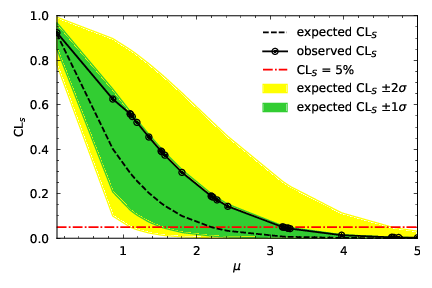

In [13]:
limit_plot=WImage(filename="figures/limit.pdf")
limit_plot

In [14]:
print(limit_results.observed_limit)

3.172464205547711


The distinction between observed and expected limits is a bit artificial when there isn't any real data to evaluate.  However, in this case the "observed_limit" part of the LimitResults gives us the POI at the intersection of the CLs=0.5 line and the black curves.  So this is the number we want to optimize -- lower is better, and below 1 is needed in order to exclude the model based on the test we're doing.  So, back to the first cell to tweak the selections and see if we can improve the results!

In [15]:
print(limit_results.expected_limit)

[1.09485801 1.5152787  2.19633791 3.24288145 4.64979925]


## Perform discovery fit

In [16]:
import pyhf
pyhf.infer.test_statistics.q0
p_observed,p_expected = pyhf.infer.hypotest(1.0, data, model, test_stat='q0', return_expected=True)

q0 test statistic only used for fit configuration with POI set to zero. Setting mu=0.


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No improvement in line search


q0 test statistic only used for fit configuration with POI set to zero. Setting mu=0.


W VariableMetricBuilder No improvement in line search


In [17]:
import scipy
scipy.stats.norm.isf(p_expected, 0, 1)

0.9756916009896549